In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

In [2]:
env = virl.Epidemic(stochastic=False, noisy=False)
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

print(env.action_space)
print(env.observation_space)
print(observation_examples)



Discrete(4)
Box(0.0, inf, (4,), float64)
[[1.86649924 0.48627571 0.98581263 3.04594724]
 [0.89526926 0.56521027 0.31096981 1.71597421]
 [1.60038102 0.83433503 0.56927203 3.66331791]
 ...
 [0.01508474 2.10663262 0.35605346 1.10955436]
 [0.63686802 0.2500333  0.85329429 0.13956822]
 [0.75695038 1.04274539 0.30308649 1.18420247]]


In [3]:
# Let's import basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing
#from sklearn.preprocessing import PolynomialFeatures # you can try with polynomial basis if you want (It is difficult!)
from sklearn.linear_model import SGDRegressor # this defines the SGD function
from sklearn.kernel_approximation import RBFSampler # this is the RBF function transformation method


feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])

func_approximator = SGDRegressor(learning_rate="constant",tol=1e-5,max_iter=1e4)



In [5]:

class LinearAprxAgent:
    def create_policy(self,func_approximator, epsilon):
        def policy_fn(state):
            """
            Input:
                state: a 2D array with the position and velocity
            Output:
                A,q_values: 
            """
            nA = self.num_of_actions
            A = np.ones(nA, dtype=float) * epsilon / nA
            
            
            state_transformed = self.feature_transformer.transform([state])
            q_values = self.func_approximator.predict(state_transformed)
           
            best_action = np.argmax(q_values)
            A[best_action] += (1.0 - epsilon)
            
            
            return A,q_values  # return the potentially stochastic policy (which is due to the exploration)

        return policy_fn # return a handle to the function so we can call it in the future
        
    def __init__(self, func_approximator,env):
        self.func_approximator = func_approximator
        self.feature_transformer = feature_transformer
        self.num_of_actions = env.action_space.n
        self.env = env
        self.policy = self.create_policy(self.func_approximator,0.0)
        self.initial_epsilon = 0.5
        self.discount = 0.99 # gamma
        self.learning_rate = 0.25 # step size, alpha
        self.episodes = 200
        self.print_out_every_x_episodes = int(self.episodes/50)
        self.times_exploited = 0
        
        # hyper parameters for epsilon
        self.initial_epsilon = 1 # initial
        self.decrease_factor = (1/self.episodes)/1.25 # epsilon
        #self.decrease_factor = 0.00075
        
    
    def run_all_episodes(self):
        all_rewards = []
        epislon = self.initial_epsilon # at the start only explore
        
        
        
        for episode in range(1, self.episodes + 1):
            states,rewards = self.run_episode(epislon)
            total_reward = np.sum(rewards)

            if episode % self.print_out_every_x_episodes == 0:
                print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epislon))
                print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
                print("times exploited " + str(self.times_exploited))
                print("-----")
            all_rewards.append(total_reward)
            epislon -= self.decrease_factor #hyperparameter
            
        return all_rewards
    
    def run_episode(self,epislon):
        rewards = []
        states = []
        actions = []
        done = False
        
        state = self.env.reset()
        states.append(state)
        
      
        
        while not done:
            random_number = np.random.random()
            if random_number < epislon:
                #explore
                action = np.random.choice(self.num_of_actions)
                
            else:
                #exploit
                action = self.get_action(state)
                self.times_exploited += 1
              
            
            new_state, reward, done, i = self.env.step(action=action)
            
            states.append(new_state)
            actions.append(action)    
            rewards.append(reward)
            
            #update policy function
            self.update(states[1:],rewards)
        
            
            state = new_state
        return states,rewards
        
    def update(self,states,rewards):
        
        #update the linear function
        self.feature_transformer.fit(states)
        states_transformed = feature_transformer.transform(states)
        
        
        self.func_approximator.fit(states_transformed,rewards)
        self.policy = self.create_policy(self.func_approximator,0.0)
                                                       
        
    def get_action(self,state):
        #linear function to get best action
        actions,q_values = self.policy(state)
        return np.argmax(actions)
    
    def get_action_text(self):
        return action_text
    
    def get_env(self):
        return env
    
    def get_chart_title(self):
        return "Action = " + action_text

In [6]:
actions = ["no intervention", "impose a full lockdown", "implement track & trace", "enforce social distancing and face masks"]
env = virl.Epidemic(stochastic=False, noisy=False)
agent = LinearAprxAgent(func_approximator,env)
rewards = agent.run_all_episodes()

plot(agent, rewards)

Episode number: 4. Total reward in episode: -1.9643815837857426. Episode executed with epsilon = 0.988
Average total reward in last 4 episodes: -1.836518461426025
times exploited 1
-----
Episode number: 8. Total reward in episode: -1.130231806415582. Episode executed with epsilon = 0.972
Average total reward in last 4 episodes: -1.552923344290527
times exploited 4
-----
Episode number: 12. Total reward in episode: -1.4645209250328408. Episode executed with epsilon = 0.956
Average total reward in last 4 episodes: -1.6397510196666802
times exploited 15
-----
Episode number: 16. Total reward in episode: -2.020651128825576. Episode executed with epsilon = 0.94
Average total reward in last 4 episodes: -1.4730022904432805
times exploited 26
-----
Episode number: 20. Total reward in episode: -1.4859726625616292. Episode executed with epsilon = 0.9239999999999999
Average total reward in last 4 episodes: -1.8721791933128054
times exploited 43
-----
Episode number: 24. Total reward in episode: -

Episode number: 168. Total reward in episode: -1.82870904123705. Episode executed with epsilon = 0.3319999999999994
Average total reward in last 4 episodes: -1.834256679046916
times exploited 2815
-----
Episode number: 172. Total reward in episode: -1.8779045466471656. Episode executed with epsilon = 0.3159999999999994
Average total reward in last 4 episodes: -1.7510546844428916
times exploited 2962
-----
Episode number: 176. Total reward in episode: -1.409826402694147. Episode executed with epsilon = 0.2999999999999994
Average total reward in last 4 episodes: -1.844324926405274
times exploited 3097
-----
Episode number: 180. Total reward in episode: -1.8537001855548894. Episode executed with epsilon = 0.28399999999999936
Average total reward in last 4 episodes: -1.6193748890616328
times exploited 3251
-----
Episode number: 184. Total reward in episode: -1.7282583852318996. Episode executed with epsilon = 0.26799999999999935
Average total reward in last 4 episodes: -1.716369448865143
t

NameError: name 'plot' is not defined

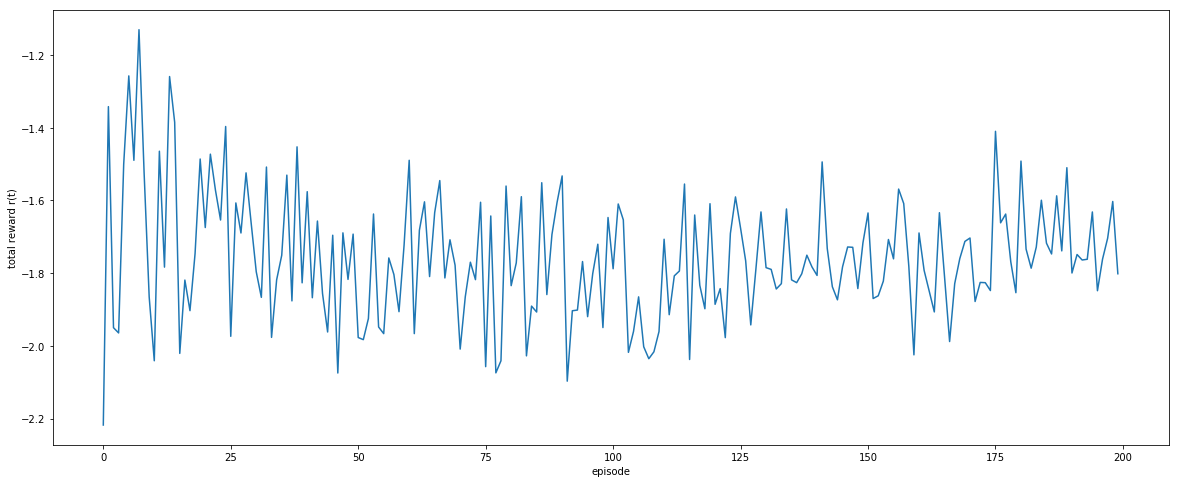

In [11]:
def plot(agent, rewards):
    fig, axes = plt.subplots(figsize=(20, 8))
    axes.plot(rewards);
    axes.set_xlabel('episode')
    axes.set_ylabel('total reward r(t)')
    
plot(agent, rewards)